<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Загрузка-данных-и-первичный-осмотр" data-toc-modified-id="Загрузка-данных-и-первичный-осмотр-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Загрузка данных и первичный осмотр</a></span></li><li><span><a href="#Преобразования-текста" data-toc-modified-id="Преобразования-текста-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Преобразования текста</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#LogisticRegression" data-toc-modified-id="LogisticRegression-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>LogisticRegression</a></span></li><li><span><a href="#DecisionTreeClassifier" data-toc-modified-id="DecisionTreeClassifier-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>DecisionTreeClassifier</a></span></li><li><span><a href="#KNeighborsClassifier" data-toc-modified-id="KNeighborsClassifier-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>KNeighborsClassifier</a></span></li></ul></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Вывод</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt 
import seaborn as sns
sns.set_style('darkgrid')

from pymystem3 import Mystem
import pymorphy2
import re

import nltk
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

## Подготовка

### Загрузка данных и первичный осмотр

Выгрузим данные и посмотрим на случайные десять элементов исходных данных.

In [2]:
df = pd.read_csv('/datasets/toxic_comments.csv')

In [3]:
df.sample(10, replace=True, random_state=42)

,text,toxic
121958,You are WRONG. \n\nJustin Thompson is mentione...,0
146867,"""\n\n British Bands? \n\nI think you've mista...",0
131932,I won't stop that. Sometimes Germanic equals G...,1
103694,Back it up. Post the line here with the refere...,0
119879,REDIRECT Talk:John Loveday (experimental physi...,0
110268,Arrangements? \n\nThere is no list of arrangem...,0
54886,"""==Image source problem with Image:Visuel2.jpg...",0
137337,"""\n\nSpeedy deletion of H2O Clan\n A tag has b...",0
87498,"Izanbardprince\n\nI* am Izanbardprince, I forg...",0
112727,"""\nHello I introduced a tag to that particul...",0


Оценим информацию по имеющимся данным.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
text     159571 non-null object
toxic    159571 non-null int64
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


Как видно, у нас отсутствуют пропуски в данных, следовательно предобработка данных не потребуется.

### Преобразования текста

Для работы с текстовыми данными нам необходимо провести векторизацию. 

In [5]:
corpus = df['text']

In [6]:
morph = pymorphy2.MorphAnalyzer()

def lemmatize(text):
    words = text.split()
    res = list()
    for word in words:
        p = morph.parse(word)[0]
        res.append(p.normal_form)

    return " ".join(res)

def clear_text(text):
    pattern = r'[^a-zA-Z]'
    cyrillic_text = re.sub(pattern, " ", text)
    
    return " ".join(cyrillic_text.split())

На данном этапе сразу можно выделить целивой признак - `target` среди остальных - `features`.

In [7]:
%%time

features = corpus.apply(lambda x: lemmatize(clear_text(x)))

CPU times: user 4min 3s, sys: 1.27 s, total: 4min 4s
Wall time: 4min 7s


In [8]:
target = df['toxic']

In [9]:
features_train, features_valid, target_train, target_valid = train_test_split(features,
                                                                              target,
                                                                              train_size=.75,
                                                                              random_state=42)

In [10]:
print('Размер тренировочной выборки:', features_train.shape)
print('Размер валидационной выборки:', features_valid.shape)

Размер тренировочной выборки: (119678,)
Размер валидационной выборки: (39893,)


In [11]:
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))
count_tf_idf = TfidfVectorizer(stop_words=stopwords)

corpus_train = features_train.values.astype('U')
tf_idf_train = count_tf_idf.fit_transform(corpus_train)

corpus_valid = features_valid.values.astype('U') 
tf_idf_valid = count_tf_idf.transform(corpus_valid)

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Итак, наши данные готовы, для того чтобы мы могли приступить к обучению моделей.

In [12]:
del df, corpus, morph, features, target, corpus_train, corpus_valid, features_train, features_valid

## Обучение

В качестве метрики классификации в данном случае выступает $F1$, которая является *гармоническим средним* между точностью ($Precision$) и полнотой ($Recall$). По отдельности обе эти метрики находятся по следующим формулам:

$$
Precision = \frac{TP}{TP + FP}
$$

$$
Recall = \frac{TP}{TP + FN}
$$

где:

 - $TP$ - истино-положительное решение;
 - $TN$ - истино-отрицательное решение;
 - $FP$ - ложно-положительное решение;
 - $FN$ - ложно-отрицательное решение.

А сама $F1$ находится таким образом:

$$
F1 = 2{\frac{Precision\times{Recall}}{Precision + Recall}}, \{F1\in{\mathbb{R}} | 0 \leq F1 \leq 1 \}
$$

Создадим функцию, которая будет проводить обучение.

In [13]:
def grid_search(model, params, features_t, features_v, target_t, target_v):
    
    #Обучение модели
    
    grid = GridSearchCV(model,
                        params,
                        cv=3,
                        scoring='f1',
                        n_jobs=-1)
    
    grid.fit(features_t, target_t)
    best_params = grid.best_params_
    prediction = grid.predict(features_v)
    
    #Classification Report
    f1 = round(f1_score(target_v, prediction), 3)
    precision = round(precision_score(target_v, prediction), 3)
    recall = round(recall_score(target_v, prediction), 3)
    roc_auc = round(roc_auc_score(target_v, prediction), 3)
    result_list = [f1, precision, recall, roc_auc]
    
    print('')
    print('Итоги обучения модели:')
    print('')
    print('- Лучшее сочетание гиперпараметров: \n  {}'.format(best_params))
    print('')
    print('- F1-мера модели: {}'.format(f1))
    print('')
    print('- Precision модели: {}'.format(precision))
    print('')
    print('- Recall модели: {}'.format(recall))
    print('')
    print('- ROC-AUC модели: {}'.format(roc_auc))
    print('')
    
    #ROC-AUC Curve Plot
    ns_probs = [0 for _ in range(len(target_v))]
    lr_probs = grid.predict_proba(features_v)
    lr_probs = lr_probs[:, 1]
    ns_fpr, ns_tpr, _ = roc_curve(target_v, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(target_v, lr_probs)
    
    f, ax = plt.subplots(1, 2, figsize=(15, 6))
    
    ax[0].plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    ax[0].plot(lr_fpr, lr_tpr, marker='.', label='ROC-AUC={}'.format(roc_auc))
    ax[0].set_title('Receiver Operating Characteristic')
    ax[0].set_xlabel('False Positive Rate')
    ax[0].set_ylabel('True Positive Rate')
    ax[0].legend()
    
    #Precision-Recall Curve Plot
    precision, recall, _ = precision_recall_curve(target_v, prediction)
    no_skill = len(target_v[target_v==1]) / len(target_v)
    
    ax[1].plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
    ax[1].plot(recall, precision, marker='.')
    ax[1].set_title('Precision-Recall curve')
    ax[1].legend(['All Positive', 'Model'])
    ax[1].set_xlabel('Recall')
    ax[1].set_ylabel('Precision')
    
    plt.show()
    
    return result_list

### LogisticRegression

Обучим модель логистической регрессии.

In [14]:
logreg = LogisticRegression(random_state=42)

In [15]:
params_logreg = {'C' : np.linspace(1e-4, 100, 5),
                 'tol' : np.linspace(1e-4, 100, 5),
                 'fit_intercept' : [True, False]}


Итоги обучения модели:

- Лучшее сочетание гиперпараметров: 
  {'C': 25.000075, 'fit_intercept': True, 'tol': 0.0001}

- F1-мера модели: 0.782

- Precision модели: 0.872

- Recall модели: 0.708

- ROC-AUC модели: 0.848



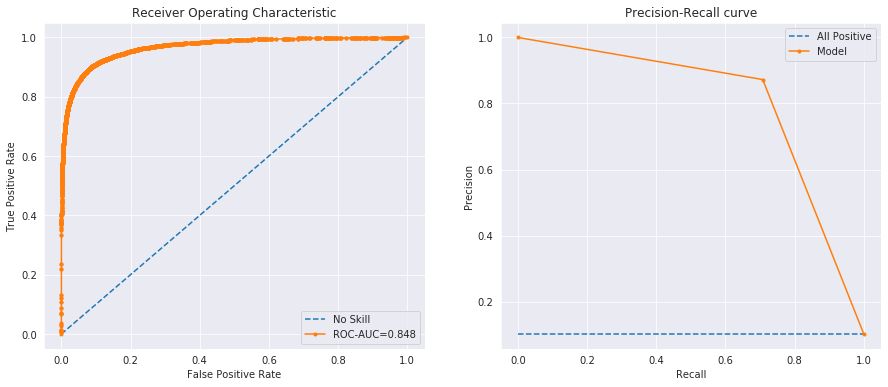

CPU times: user 5min 38s, sys: 4min 57s, total: 10min 35s
Wall time: 10min 36s


In [16]:
%%time

result_list_logreg = grid_search(logreg, params_logreg, tf_idf_train, tf_idf_valid, target_train, target_valid)

### DecisionTreeClassifier

Опробуем модель **DecisionTreeClassifier**.

In [17]:
tree = DecisionTreeClassifier(random_state=42)

In [18]:
params_tree = {'max_depth':[5, 10, 15], 
               'min_samples_split':[5, 7, 9], 
               'min_samples_leaf':[3, 5, 7],
               'criterion': ['gini', 'entropy']}


Итоги обучения модели:

- Лучшее сочетание гиперпараметров: 
  {'criterion': 'gini', 'max_depth': 15, 'min_samples_leaf': 3, 'min_samples_split': 5}

- F1-мера модели: 0.625

- Precision модели: 0.9

- Recall модели: 0.478

- ROC-AUC модели: 0.736



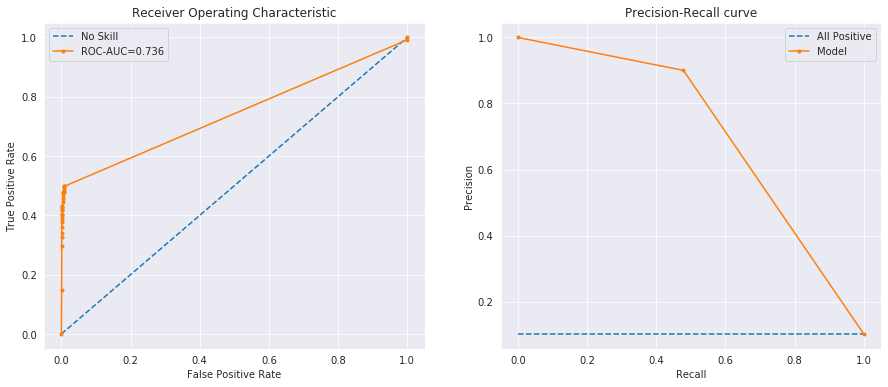

CPU times: user 29min 56s, sys: 0 ns, total: 29min 56s
Wall time: 30min 9s


In [19]:
%%time

result_list_tree = grid_search(tree, params_tree, tf_idf_train, tf_idf_valid, target_train, target_valid)

### KNeighborsClassifier

In [20]:
knn = KNeighborsClassifier()

In [21]:
params_knn = {'leaf_size' : [10, 20],
              'n_neighbors': [5, 10]}


Итоги обучения модели:

- Лучшее сочетание гиперпараметров: 
  {'leaf_size': 10, 'n_neighbors': 5}

- F1-мера модели: 0.266

- Precision модели: 0.845

- Recall модели: 0.158

- ROC-AUC модели: 0.577



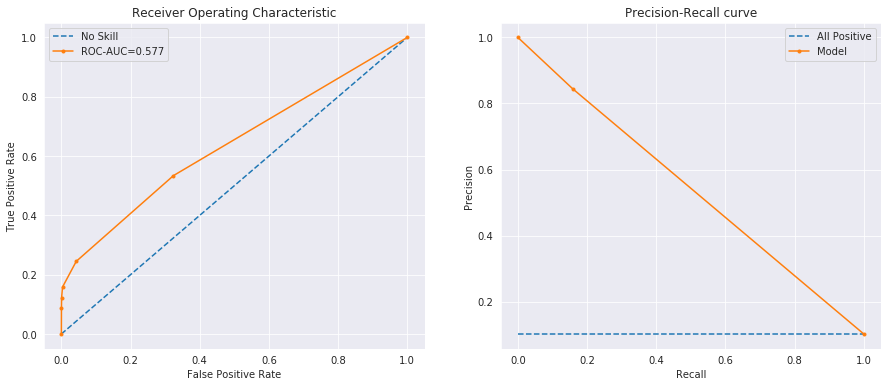

CPU times: user 21min 40s, sys: 7min 50s, total: 29min 31s
Wall time: 29min 55s


In [22]:
%%time

result_list_knn = grid_search(knn, params_knn, tf_idf_train, tf_idf_valid, target_train, target_valid)

## Вывод

In [23]:
dict = {'LogisticRegression' : result_list_logreg,
        'DecisionTreeClassifier' : result_list_tree,
        'KNeighborsClassifier' : result_list_knn}

result_tab = pd.DataFrame.from_dict(dict,
                                    orient='index',
                                    columns=['F1-score', 'Precision', 'Recall', 'ROC-AUC']).sort_values(by='F1-score',
                                                                                                        ascending=False)
result_tab

,F1-score,Precision,Recall,ROC-AUC
LogisticRegression,0.782,0.872,0.708,0.848
DecisionTreeClassifier,0.625,0.900,0.478,0.736
KNeighborsClassifier,0.266,0.845,0.158,0.577


Итак, исходные текстовые данные мы преобразовали при помощи *TF-IDF* подхода в векторный формат. Далее было обучено несколько моделей машинного обучения:

 * **LogisticRegression**
 * **DecisionTreeClassifier**
 * **KNeighborsClassifier**
 
Лучшие показатели метрики $F1$ равный **LogisticRegression** при обучение по сетке был у алгоритма **0.782**.